### Allele Frequency Trajectories

In [3]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
from shutil import which
import os
import re as re
from datetime import date

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/covid19_data/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### Check whether required bins are available
req_bins = ["mafft"] 
for b in req_bins:
    s = which(b)
    if not s:
        print(f"Make sure to install {b} and have in path. I cannot find it!")
        
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

sys.path.append("./python3/")
from manipulate_fasta import fasta_iter_raw, fasta_iter

Current machine: compute-a-16-161.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/covid19_data


### Define Functions

In [4]:
def load_merged_df(var_path="./output/tables/march30/derived.tsv",
                   meta_path="./data/mar20/metadata31.tsv",
                   epi_col = "gisaid_epi_isl"):
    """Load variant df and meta df, and merge on epi_col"""
    df = pd.read_csv(var_path, sep="\t")
    df[epi_col] = df["iid"].str.split("|").str[1]  # Split out the EPI ID
    df_meta = pd.read_csv(meta_path, sep="\t")
    df1 = pd.merge(df, df_meta, on=epi_col)
    print(f"Merged to {len(df1)}/{len(df)} Individuals")
    return df1

### Load the variant Data

In [33]:
df1 = load_merged_df(var_path="./output/tables/derived_common_snps.tsv",
                     meta_path="./data/apr20/metadata.tsv")
df1 = df1[~(df1["date"]=="2020-02-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-01-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-03-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-01-01")].copy()
df1["date1"] =  pd.to_datetime(df1["date"]) # New Sort Column
len(df1)

Merged to 3305/3325 Individuals


3281

### Plot Cumulative Frequency

In [34]:
df2 = df1.copy()
pos= f"23402"
df2 = df2[df2["date1"]!="2020-01-01"]
df2 = df2.sort_values(by="date1")
df2 = df2[df2['host']=="Human"]
print(f"Human Samples: {len(df2)}")
derived = df2[pos]

dts = df2["date1"]
cum_count = np.arange(len(df2))+1
cum_der = np.cumsum(derived)
all_freq = cum_der / cum_count

Human Samples: 3240


Saved to ./figures/dumpster/all_freq_full.png


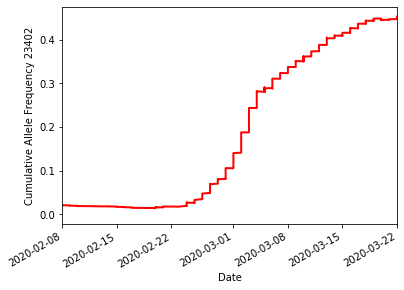

In [9]:
savepath="./figures/dumpster/all_freq_full.png"

plt.figure()
ax=plt.gca()
ax.plot(dts, all_freq, lw=2, c="r")

#plt.plot(date, cum_count)
ax.set_ylabel(f"Cumulative Allele Frequency {23402}")
ax.set_xlabel("Date")
plt.xticks(rotation=30, ha='right')
#ax.set_xlim([date("2020-02-01"), date("2020-04-01")])
ax.set_xlim([date(2020, 2, 8), date(2020, 3, 22)])
if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=200)
    print(f"Saved to {savepath}")

plt.show()

In [22]:
def plot_freq_traj_group(savepath="./figures/dumpster/all_freq_country_april.png",
                         pos= f"23402", min_cases = 10, col = "country",
                         countries = ["Netherlands", "United Kingdom", "France", "Belgium", 
                                      "Switzerland", "Germany", "Luxembourg", "USA", "Canada", "Australia", "China"]):
    plt.figure()
    ax=plt.gca()

    for ctry in countries:
        df_t = df2[df2[col]==ctry]

        derived = df_t[pos]
        dts = df_t["date1"]
        cum_count = np.arange(len(df_t))+1
        cum_der = np.cumsum(derived)
        all_freq = cum_der / cum_count

        ax.plot(dts[min_cases:], all_freq[min_cases:], label=ctry)

    #plt.plot(date, cum_count)
    ax.set_ylabel(f"Cumulative Allele Frequency {23402}")
    ax.set_xlabel("Date")
    ax.set_xlim([date(2020, 2, 8), date(2020, 3, 22)])
    ax.legend(loc = "upper left")
    plt.xticks(rotation=30, ha='right')

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=200)
        print(f"Saved to {savepath}")

    plt.show()

Saved to ./figures/dumpster/all_freq_country_april.png


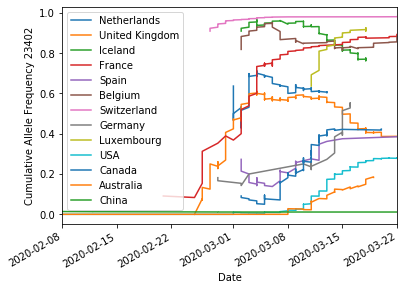

In [50]:
plot_freq_traj_group(savepath="./figures/dumpster/all_freq_country_april.png",
                     pos= f"3036", min_cases = 10, col = "country",
                     countries = ["Netherlands", "United Kingdom", "Iceland", "France", "Spain", "Belgium", 
                                  "Switzerland", "Germany", "Luxembourg", "USA", "Canada", "Australia", 
                                  "China"])

Saved to ./figures/dumpster/all_freq_country_april.png


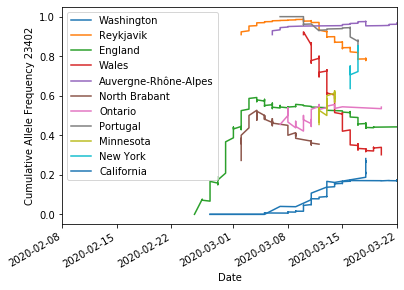

In [32]:
plot_freq_traj_group(savepath="./figures/dumpster/all_freq_country_april.png",
                     pos= f"23402", min_cases = 10, col = "division",
                     countries = ["Washington", "Reykjavik", "England", "Wales",
                                  "Auvergne-Rhône-Alpes", "North Brabant", "Ontario", "Portugal",
                                 "Minnesota", "New York", "California"])

In [30]:
df2["division"].value_counts()[:20]

Washington              526
Reykjavik               343
England                 299
Wales                   219
Shanghai                 96
Guangdong                79
unknown                  70
Liège                    64
Auvergne-Rhône-Alpes     63
North Brabant            62
Ontario                  59
British Columbia         59
Portugal                 44
New South Wales          44
Minnesota                42
California               39
New York                 36
South Holland            34
Netherlands              32
Hauts de France          31
Name: division, dtype: int64

In [27]:
df2.columns

Index(['iid', 'iid_clean', 'cov', 'include', 'aligned_path', '240', '1058',
       '3036', '8781', '11082', '14407', '14804', '17746', '17857', '18059',
       '23402', '25562', '26143', '27045', '28143', '28880', '28881', '28882',
       'gisaid_epi_isl', 'strain', 'virus', 'genbank_accession', 'date',
       'region', 'country', 'division', 'location', 'country_exposure',
       'division_exposure', 'segment', 'length', 'host', 'age', 'sex',
       'originating_lab', 'submitting_lab', 'authors', 'url', 'title',
       'date_submitted', 'date1'],
      dtype='object')

In [40]:
df1["host"].value_counts()

Human                  3263
human                     9
Manis javanica            8
Rhinolophus affinis       1
Name: host, dtype: int64

In [63]:
df1[df1["host"].str.lower()!="human"][[f"3036", f"14407"]]

,3036,14407
51,False,False
63,False,False
64,False,False
68,False,False
69,False,False
70,False,False
71,False,False
662,True,False
2761,False,False


In [58]:
df1[[f"3036", f"23402"]]

,3036,23402
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
3300,False,False
3301,False,False
3302,False,False
3303,False,False


In [62]:
np.corrcoef(df1["14407"], df1["23402"]) # "3036", "14407" "23402"

array([[1.        , 0.98522176],
       [0.98522176, 1.        ]])